In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed,SimpleRNN,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")
df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")


In [3]:
df_merged = pd.merge(df, df_truth, on='id')
df_merged

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,more
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,98
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,98
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,98
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,98
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,99,181,-0.0015,-0.0001,100,518.67,643.72,1600.39,1428.03,14.62,...,2388.29,8123.55,8.4885,0.03,396,2388,100,38.50,23.0425,20
20427,99,182,-0.0027,-0.0003,100,518.67,643.52,1605.33,1430.32,14.62,...,2388.27,8130.99,8.5124,0.03,393,2388,100,38.39,22.9674,20
20428,99,183,-0.0031,-0.0003,100,518.67,643.96,1606.95,1427.90,14.62,...,2388.31,8126.90,8.5374,0.03,395,2388,100,38.57,23.1440,20
20429,99,184,-0.0010,-0.0001,100,518.67,644.10,1600.20,1436.54,14.62,...,2388.33,8125.66,8.5592,0.03,395,2388,100,38.45,23.0478,20


In [4]:
# Step 1: Get the maximum cycle for each engine
max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
max_cycle_per_engine.columns = ['id', 'max_cycle']

# Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

# Step 3: Calculate the actual failure cycle (when engine will fail)
df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

# Step 4: Merge this back with the main DataFrame to compute remaining cycles
df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

# Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
df = df.drop('failure_cycle',axis=1)

In [5]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,remaining_cycles
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,289
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,288
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,287
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,286
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,285


In [6]:
# Assuming `df` is the provided DataFrame
# Split engines into train and test ensuring no overlap of engine IDs
engine_ids = df['id'].unique()
train_ids, test_ids = train_test_split(engine_ids, test_size=0.2, random_state=42)

# Create train and test sets
train_df = df[df['id'].isin(train_ids)].reset_index(drop=True)
test_df = df[df['id'].isin(test_ids)].reset_index(drop=True)


In [7]:
# Features and targets
features_cols = [col for col in df.columns if col not in ['id', 'cycle', 'remaining_cycles']]
X_train_individual = train_df[features_cols].values
y_train_individual = train_df['remaining_cycles'].values

X_test_individual = test_df[features_cols].values
y_test_individual = test_df['remaining_cycles'].values


In [8]:
# Train generator for individual row-wise model
train_gen_individual = TimeseriesGenerator(
    data=X_train_individual, 
    targets=y_train_individual, 
    length=1,          # Use a length of 1 for row-wise sequences
    batch_size=32
)

# Test generator for individual row-wise model
test_gen_individual = TimeseriesGenerator(
    data=X_test_individual, 
    targets=y_test_individual, 
    length=1,          # Use a length of 1 for row-wise sequences
    batch_size=32
)



In [9]:
window_size = 5

# Train generator for sliding window model
train_gen_window = TimeseriesGenerator(
    data=train_df[features_cols].values,
    targets=train_df['remaining_cycles'].values,
    length=window_size,
    batch_size=32
)

# Test generator for sliding window model
test_gen_window = TimeseriesGenerator(
    data=test_df[features_cols].values,
    targets=test_df['remaining_cycles'].values,
    length=window_size,
    batch_size=32
)

In [10]:
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor the validation loss
    factor=0.5,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,         # Minimum learning rate
    verbose=1            # Print a message when learning rate is reduced
)


In [11]:
# Define model for individual row-wise sequence
model_individual = Sequential([
    SimpleRNN(64, input_shape=(1, X_train_individual.shape[1]), activation='relu', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model with Adam optimizer
model_individual.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')


In [12]:
# Reshape data to (samples, time steps, features) for RNN input
X_train_individual = X_train_individual.reshape((X_train_individual.shape[0], 1, X_train_individual.shape[1]))
X_test_individual = X_test_individual.reshape((X_test_individual.shape[0], 1, X_test_individual.shape[1]))


In [13]:
# Train model
# Train model with early stopping and learning rate reduction using the generator
individual_history = model_individual.fit(
    train_gen_individual,
    epochs=100,
    validation_data=test_gen_individual,
    callbacks=[reduce_lr]
)


Epoch 1/100
517/517 [==============================] - 4s 4ms/step - loss: 303663.4375 - val_loss: 8547.5635 - lr: 1.0000e-04
Epoch 2/100
517/517 [==============================] - 1s 3ms/step - loss: 43977.7227 - val_loss: 7203.5059 - lr: 1.0000e-04
Epoch 3/100
517/517 [==============================] - 2s 3ms/step - loss: 22574.4473 - val_loss: 10640.7520 - lr: 1.0000e-04
Epoch 4/100
517/517 [==============================] - 1s 3ms/step - loss: 16373.3555 - val_loss: 9227.5674 - lr: 1.0000e-04
Epoch 5/100
517/517 [==============================] - 1s 3ms/step - loss: 12958.3320 - val_loss: 10112.8506 - lr: 1.0000e-04
Epoch 6/100
517/517 [==============================] - 1s 3ms/step - loss: 11366.7773 - val_loss: 7601.6504 - lr: 1.0000e-04
Epoch 7/100
501/517 [============================>.] - ETA: 0s - loss: 10132.0342
Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
517/517 [==============================] - 1s 3ms/step - loss: 10055.3760 - val_loss: 728

In [14]:
# Define model for sliding window sequence
model_window = Sequential([
    SimpleRNN(64, input_shape=(window_size, len(features_cols)), activation='relu', return_sequences=True),
    Dropout(0.2),
    SimpleRNN(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

# Compile model with Adam optimizer
model_window.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')


In [15]:
# Train model with early stopping and learning rate reduction using the generator
window_history = model_window.fit(
    train_gen_window,
    epochs=100,
    validation_data=test_gen_window,
    callbacks=[reduce_lr]
)


Epoch 1/100
517/517 [==============================] - 5s 5ms/step - loss: 405745.0938 - val_loss: 6350.2671 - lr: 1.0000e-04
Epoch 2/100
517/517 [==============================] - 2s 5ms/step - loss: 40303.8164 - val_loss: 7473.0503 - lr: 1.0000e-04
Epoch 3/100
517/517 [==============================] - 3s 5ms/step - loss: 20804.6387 - val_loss: 9605.7656 - lr: 1.0000e-04
Epoch 4/100
517/517 [==============================] - 3s 5ms/step - loss: 14743.7939 - val_loss: 7403.5029 - lr: 1.0000e-04
Epoch 5/100
517/517 [==============================] - 3s 5ms/step - loss: 12161.6992 - val_loss: 8133.8442 - lr: 1.0000e-04
Epoch 6/100
506/517 [============================>.] - ETA: 0s - loss: 10436.9307
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
517/517 [==============================] - 3s 5ms/step - loss: 10436.9883 - val_loss: 6426.0718 - lr: 1.0000e-04
Epoch 7/100
517/517 [==============================] - 3s 5ms/step - loss: 9468.2607 - val_loss: 7592.7

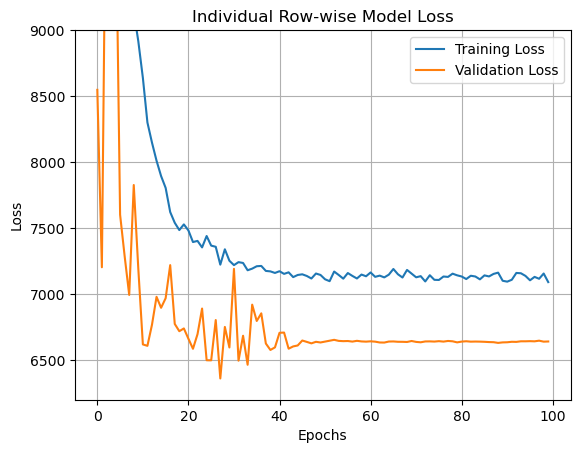

In [16]:
# Plotting function
def plot_loss(history, title,lim):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.ylim(lim)
    plt.grid(True)
    plt.show()

# Plot for individual row-wise model
plot_loss(individual_history, 'Individual Row-wise Model Loss',(6200,9000))


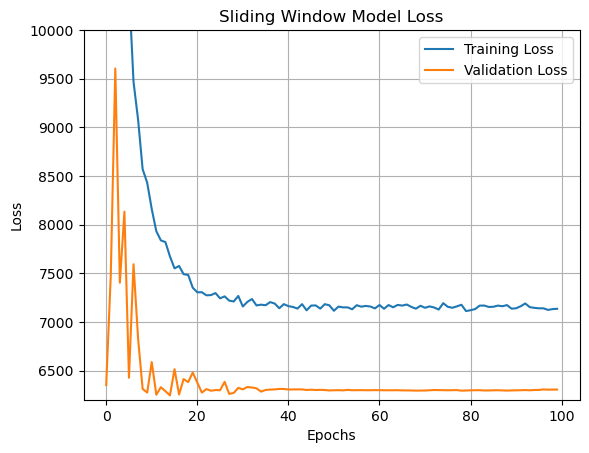

In [17]:

# Plot for sliding window model
plot_loss(window_history, 'Sliding Window Model Loss',(6200,10000))
